# Final Project

### Files and imports 

In [1]:
import pandas as pd
import glob
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

DATA = "./csv/"

In [2]:
# ese *1.csv solo pilla los originales porque los tratados acaban en t.csv
files = glob.glob(f"{DATA}*1.csv")

In [3]:
files.sort()

In [4]:
files

['./csv\\02_197706_1.csv',
 './csv\\02_197903_1.csv',
 './csv\\02_198210_1.csv',
 './csv\\02_198606_1.csv',
 './csv\\02_198910_1.csv',
 './csv\\02_199306_1.csv',
 './csv\\02_199603_1.csv',
 './csv\\02_200003_1.csv',
 './csv\\02_200403_1.csv',
 './csv\\02_200803_1.csv',
 './csv\\02_201111_1.csv',
 './csv\\02_201512_1.csv',
 './csv\\02_201606_1.csv',
 './csv\\02_201904_1.csv',
 './csv\\02_201911_1.csv']

#### Correct the files

In [5]:
for file in files:

    test = pd.read_csv(file)
    
    # normaliza nombres de municipio y provincia
    test["Nombre de Municipio"] = test["Nombre de Municipio"].apply(utils.proper)
    test["Nombre de Provincia"] = test["Nombre de Provincia"].apply(utils.proper)

    # se queda solo con las siglas del partido (normalizado)
    test.rename(columns={column: utils.acronym(column) for column in test.columns[13:]}, inplace=True)
    
    test = test.rename(columns={'PODEMOS-IU-EQUO': 'PODEMOS', 'PODEMOS-IU': 'PODEMOS', 'PODEMOS-COM': 'PODEMOS', 
                                'PODEMOS-COMPROMÍS-EUPV': 'PODEMOS', 'PODEMOS-EN': 'PODEMOS', 'PODEMOS-EN MAREA-ANOVA-EU': 
                                'PODEMOS', 'EN COMÚ': 'PODEMOS', 'CCA-PNC-NC': 'CCA-PNC', 'COMPROMÍS 2019': 'MÉS COMPROMÍS', 
                                "C'S": 'CS', 'ECP-GUANYEM EL CANVI': 'PODEMOS', 'NCA': 'CCA-PNC', 'CC-NC-PNC': 'CCA-PNC', 
                                'AMAIUR': 'EH BILDU', 'CDC': 'CIU', 'ERC-SOBIRANISTES': 'ERC', 'ERC-CATSÍ': 'ERC', 
                                'ERC-CATSI': 'ERC', 'ESQUERRA': 'ERC', 'ECP': 'PODEMOS', 'P.S.O.E.': 'PSOE', 'PSOE-PROGR.': 
                                'PSOE', 'P.P.': 'PP'})
    
    # calcula el partido con mas votos, cuantos votos y lo guarda
    utils.compute_popular(test).to_csv(f"{file[:-4]}_treat.csv")

In [6]:
# test.columns[:13] common vote, town info. Dropping this gives list of political parties
test.drop(columns=test.columns[:13]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8131 entries, 0 to 8130
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   PSOE                       8131 non-null   int64 
 1   PP                         8131 non-null   int64 
 2   VOX                        8131 non-null   int64 
 3   PODEMOS                    8131 non-null   int64 
 4   ERC                        8131 non-null   int64 
 5   CS                         8131 non-null   int64 
 6   JXCAT-JUNTS                8131 non-null   int64 
 7   PODEMOS                    8131 non-null   int64 
 8   EAJ-PNV                    8131 non-null   int64 
 9   EH BILDU                   8131 non-null   int64 
 10  MÁS PAÍS-EQUO              8131 non-null   int64 
 11  CUP-PR                     8131 non-null   int64 
 12  PODEMOS-EU                 8131 non-null   int64 
 13  CCA-PNC                    8131 non-null   int64 
 14  NA+     

#### Get elections from 2000 until now

In [7]:
files_treated = glob.glob(f"{DATA}02_20*t.csv")
common_columns = ["Unnamed: 0", "Nombre de Comunidad", "Código de Provincia", "Nombre de Provincia", "Código de Municipio",
                  "Nombre de Municipio"]
char_columns = ["Unnamed: 0", "Nombre de Comunidad", "Código de Provincia", "Nombre de Provincia", "Código de Municipio",
                   "Nombre de Municipio", "Población", "Número de mesas", "Popular"]
elections20_ = pd.read_csv(files_treated[0])
elections20_ = elections20_.reset_index(drop=True)
for col in elections20_.columns:
    if col not in char_columns:
        elections20_[col] = elections20_[col]/elections20_["Población"]
elections20_ = elections20_.drop(columns=["Población","Unnamed: 0"])
for col in elections20_.columns:
    if col not in common_columns:
        elections20_.rename(columns={col: col+"_2000_03"},inplace=True) 
for file in files_treated[1:]:
    ele = pd.read_csv(file)
    ele.rename(columns={"Población ": "Población"},inplace=True) 
    ele = ele.reset_index(drop=True)
    name = '_'+file.split('_')[1][:4]+'_'+file.split('_')[1][4:]
    for col in ele.columns:
        if col not in char_columns:
            ele[col] = ele[col]/ele["Población"]
    for col in ele.columns:
        if col not in common_columns:
            ele.rename(columns={col: col+f'{name}'},inplace=True) 
    elections20_ = pd.merge(elections20_, ele, on=["Nombre de Comunidad", "Código de Provincia",
                                                     "Nombre de Provincia", "Código de Municipio",
                                                     "Nombre de Municipio"],how = 'outer',suffixes=("",f'{name}'))
    elections20_ = elections20_.drop(columns=["Población"+f'{name}',"Unnamed: 0"])

### Analysis of elections from 2010 until now

In [8]:
p1111 = elections20_["Popular_2011_11"].value_counts()
p1215 = elections20_["Popular_2015_12"].value_counts()
p0616 = elections20_["Popular_2016_06"].value_counts()
p0419 = elections20_["Popular_2019_04"].value_counts()
p1119 = elections20_["Popular_2019_11"].value_counts()
popular201_ = p1111.to_frame().join(p1215, how='outer').join(p0616, how='outer').join(p0419, how='outer').join(p1119, 
                    how='outer').sort_values(by=['Popular_2019_11', 'Popular_2019_04'], ascending=False)
popular201_ = popular201_.replace(np.nan,0.0)
popular201_.head(15)

,Popular_2011_11,Popular_2015_12,Popular_2016_06,Popular_2019_04,Popular_2019_11
PSOE,1115.0,1561.0,1244.0,4076.0,3586.0
PP,5862.0,5070.0,5440.0,2464.0,2810.0
ERC,5.0,267.0,474.0,747.0,622.0
VOX,0.0,0.0,0.0,72.0,278.0
JXCAT-JUNTS,0.0,0.0,0.0,107.0,241.0
EH BILDU,195.0,132.0,95.0,146.0,180.0
EAJ-PNV,91.0,122.0,118.0,159.0,153.0
NA+,0.0,0.0,0.0,117.0,106.0
PODEMOS,0.0,456.0,480.0,75.0,58.0
¡TERUEL EXISTE!,0.0,0.0,0.0,0.0,40.0


#### Predicting elections on nov 2019

In [33]:
X = popular201_.copy().drop(columns='Popular_2019_11')
y = popular201_['Popular_2019_11']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 0)

linreg_model = LinearRegression()
linreg_model.fit(Xtrain, ytrain)
prediction_linreg = linreg_model.predict(Xtest)

dtree = tree.DecisionTreeRegressor()
dtree.fit(Xtrain, ytrain)
prediction_dtree = dtree.predict(Xtest)

rforest = RandomForestRegressor()
rforest.fit(Xtrain, ytrain)
prediction_rforest = rforest.predict(Xtest)

nn = MLPRegressor(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state = 1)
nn.fit(Xtrain, ytrain)
prediction_nn = nn.predict(Xtest)

results201_ = ytest.to_frame()
results201_['Prediciton_linreg'] = prediction_linreg.astype(int).astype(float)
results201_['Prediciton_dtree'] = prediction_dtree.astype(int).astype(float)
results201_['Prediciton_rforest'] = prediction_rforest.astype(int).astype(float)
results201_['Prediciton_nn'] = prediction_nn.astype(int).astype(float)

results201_

,Popular_2019_11,Prediciton_linreg,Prediciton_dtree,Prediciton_rforest,Prediciton_nn
CCA-PNC,7.0,25.0,0.0,0.0,18.0
PCTE,0.0,12.0,0.0,4.0,1.0
IU-LV,0.0,12.0,0.0,0.0,0.0
PPSO,1.0,13.0,0.0,4.0,2.0
ERC,622.0,674.0,180.0,104.0,720.0
IU-UPEC,0.0,11.0,0.0,1.0,0.0
MÉS,0.0,11.0,0.0,1.0,0.0
GBAI,1.0,14.0,0.0,0.0,0.0
PRC,31.0,25.0,3.0,3.0,21.0


In [34]:
mse_linreg = mean_squared_error(ytest, prediction_linreg)
mse_dtree = mean_squared_error(ytest, prediction_dtree)
mse_rforest = mean_squared_error(ytest, prediction_rforest)
mse_nn = mean_squared_error(ytest, prediction_nn)

mse_results = {'mse_linreg': mse_linreg, 'mse_dtree': mse_dtree, 'mse_rforest': mse_rforest, 'mse_nn': mse_nn}
mse_results

{'mse_linreg': 448.56995608879566,
 'mse_dtree': 21799.083333333332,
 'mse_rforest': 29806.930679833335,
 'mse_nn': 1092.1177401879515}

#### Analysis of linear regression of predicting elections on nov 2019

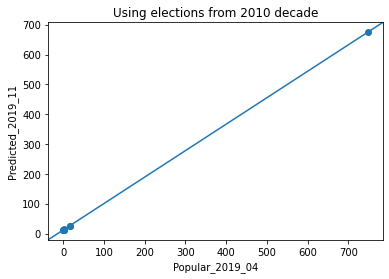

In [36]:
fig, axs = plt.subplots()
plt.scatter(Xtest['Popular_2019_04'], prediction_linreg)
plt.plot([0,1],[0,1], transform=axs.transAxes)
plt.title('Using elections from 2010 decade')
plt.xlabel('Popular_2019_04')
plt.ylabel('Predicted_2019_11')
plt.show()

#### Analysis of NN of predicting elections on nov 2019

In [12]:
# Use Shap explainer to interpret values in the test set:
shap.initjs() 
explainer = shap.KernelExplainer(nn.predict, Xtrain)
shap_values = explainer.shap_values(X)

  0%|          | 0/33 [00:00<?, ?it/s]

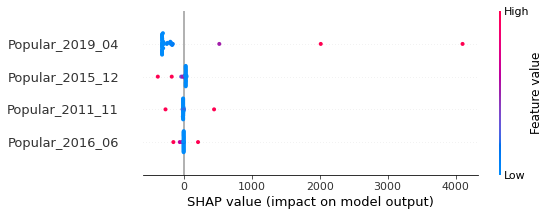

In [13]:
shap.summary_plot(shap_values, X)

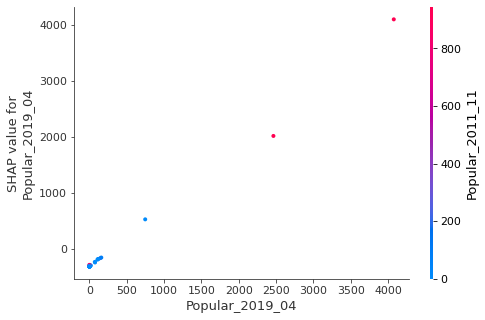

In [14]:
shap.dependence_plot("Popular_2019_04", shap_values, X)

### Analysis of elections from 2000 until now

In [15]:
p0300 = elections20_["Popular_2000_03"].value_counts().to_frame()
p0304 = elections20_["Popular_2004_03"].value_counts()
p0308 = elections20_["Popular_2008_03"].value_counts()
popular20_ = p0300.join(p0304, how='outer').join(p0308, how='outer').join(p1111, how='outer').join(p1215, 
                    how='outer').join(p0616, how='outer').join(p0419, how='outer').join(p1119, 
                    how='outer').sort_values(by=['Popular_2019_11', 'Popular_2019_04'], ascending=False)
popular20_ = popular20_.replace(np.nan,0.0)
popular20_.head(15)

,Popular_2000_03,Popular_2004_03,Popular_2008_03,Popular_2011_11,Popular_2015_12,Popular_2016_06,Popular_2019_04,Popular_2019_11
PSOE,1742.0,2873.0,3259.0,1115.0,1561.0,1244.0,4076.0,3586.0
PP,5316.0,4290.0,4138.0,5862.0,5070.0,5440.0,2464.0,2810.0
ERC,0.0,127.0,14.0,5.0,267.0,474.0,747.0,622.0
VOX,0.0,0.0,0.0,0.0,0.0,0.0,72.0,278.0
JXCAT-JUNTS,0.0,0.0,0.0,0.0,0.0,0.0,107.0,241.0
EH BILDU,0.0,0.0,0.0,195.0,132.0,95.0,146.0,180.0
EAJ-PNV,190.0,211.0,173.0,91.0,122.0,118.0,159.0,153.0
NA+,0.0,0.0,0.0,0.0,0.0,0.0,117.0,106.0
PODEMOS,0.0,0.0,0.0,0.0,456.0,480.0,75.0,58.0
¡TERUEL EXISTE!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0


#### Predicting elections on nov 2019

In [16]:
X = popular20_.copy().drop(columns='Popular_2019_11')
y = popular20_['Popular_2019_11']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 0)

linreg_model = LinearRegression()
linreg_model.fit(Xtrain, ytrain)
prediction_linreg = linreg_model.predict(Xtest)

dtree = tree.DecisionTreeRegressor()
dtree.fit(Xtrain, ytrain)
prediction_dtree = dtree.predict(Xtest)

rforest = RandomForestRegressor()
rforest.fit(Xtrain, ytrain)
prediction_rforest = rforest.predict(Xtest)

nn = MLPRegressor(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state = 18)
nn.fit(Xtrain, ytrain)
prediction_nn = nn.predict(Xtest)

results20_ = ytest.to_frame()
results20_['Prediciton_linreg'] = prediction_linreg.astype(int).astype(float)
results20_['Prediciton_dtree'] = prediction_dtree.astype(int).astype(float)
results20_['Prediciton_rforest'] = prediction_rforest.astype(int).astype(float)
results20_['Prediciton_nn'] = prediction_nn.astype(int).astype(float)

results20_

,Popular_2019_11,Prediciton_linreg,Prediciton_dtree,Prediciton_rforest,Prediciton_nn
FE,0.0,4.0,0.0,0.0,6.0
FAC,0.0,4.0,0.0,2.0,6.0
LV-GV,0.0,4.0,0.0,5.0,6.0
CDN,0.0,4.0,0.0,0.0,6.0
CCA-PNC,7.0,19.0,1.0,1.0,18.0
ERC,622.0,716.0,153.0,106.0,661.0
F.A.,0.0,4.0,0.0,0.0,6.0
UV,0.0,4.0,0.0,0.0,6.0
ARALAR,0.0,4.0,0.0,0.0,6.0
UPYD,0.0,4.0,0.0,2.0,6.0


In [17]:
mse_linreg = mean_squared_error(ytest, prediction_linreg)
mse_dtree = mean_squared_error(ytest, prediction_dtree)
mse_rforest = mean_squared_error(ytest, prediction_rforest)
mse_nn = mean_squared_error(ytest, prediction_nn)

mse_results = {'mse_linreg': mse_linreg, 'mse_dtree': mse_dtree, 'mse_rforest': mse_rforest, 'mse_nn': mse_nn}
mse_results

{'mse_linreg': 2836.636754935806,
 'mse_dtree': 15933.8,
 'mse_rforest': 31976.508980195355,
 'mse_nn': 7532.392444289404}

#### Analysis of linear regression of predicting elections on nov 2019

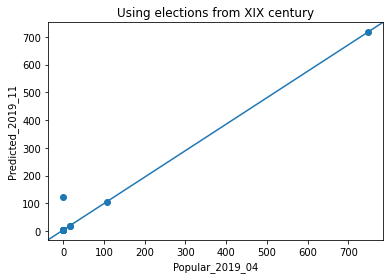

In [32]:
fig, axs = plt.subplots()
plt.scatter(Xtest['Popular_2019_04'], prediction_linreg)
plt.plot([0,1],[0,1], transform=axs.transAxes)
plt.title('Using elections from XIX century')
plt.xlabel('Popular_2019_04')
plt.ylabel('Predicted_2019_11')
plt.show()

#### Analysis of NN of predicting elections on nov 2019

In [19]:
# Use Shap explainer to interpret values in the test set:
shap.initjs() 
explainer = shap.KernelExplainer(nn.predict, Xtrain)
shap_values = explainer.shap_values(X)

  0%|          | 0/57 [00:00<?, ?it/s]

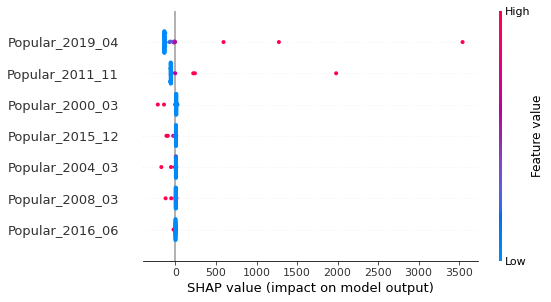

In [20]:
shap.summary_plot(shap_values, X)

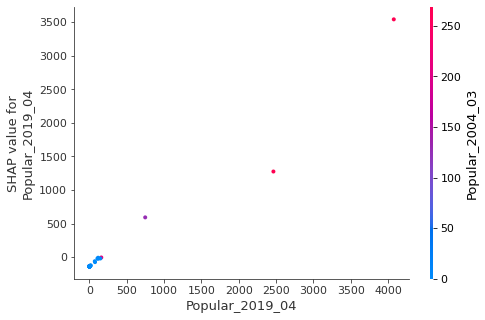

In [21]:
shap.dependence_plot("Popular_2019_04", shap_values, X)

### Analysis of common political parties in 2019

In [22]:
files_treated2 = glob.glob(f"{DATA}02_2019*t.csv")
ele1 = pd.read_csv(files_treated2[0])
ele1 = ele1.reset_index(drop=True)
ele2 = pd.read_csv(files_treated2[1])
ele2 = ele2.reset_index(drop=True)
elections2019 = pd.merge(ele1, ele2, on=["Unnamed: 0", "Nombre de Comunidad","Código de Provincia","Nombre de Provincia",
                                     "Código de Municipio","Nombre de Municipio", "Población"],suffixes=("_apr","_nov"))

In [23]:
elections2019['Número de mesas_apr'].apply(lambda x: float(x))
elections2019['Número de mesas_nov'].apply(lambda x: float(x))
elections2019['Total censo electoral_apr'].apply(lambda x: float(x))
elections2019['Total censo electoral_nov'].apply(lambda x: float(x))
elections2019['Popular votos_apr'].apply(lambda x: float(x))
elections2019['Popular votos_nov'].apply(lambda x: float(x))
elections2019 = elections2019.replace(np.nan,0.0)

In [24]:
elections2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8131 entries, 0 to 8130
Columns: 159 entries, Unnamed: 0 to Popular votos_nov
dtypes: int64(154), object(5)
memory usage: 9.9+ MB


In [25]:
for col in elections2019.columns:
    if col not in ["Unnamed: 0", "Nombre de Comunidad", "Código de Provincia", "Nombre de Provincia", "Código de Municipio",
                   "Nombre de Municipio", "Población", "Número de mesas_apr", "Número de mesas_nov", "Popular_apr", 
                   "Popular_nov"]:
        elections2019[col] = elections2019[col]/elections2019["Población"]

In [26]:
elections2019["Popular_apr"].value_counts().to_frame().join(elections2019["Popular_nov"].value_counts(), how='outer').sort_values(by=['Popular_nov', 'Popular_apr'], ascending=False)

,Popular_apr,Popular_nov
PSOE,4076.0,3586.0
PP,2464.0,2810.0
ERC,747.0,622.0
VOX,72.0,278.0
JXCAT-JUNTS,107.0,241.0
EH BILDU,146.0,180.0
EAJ-PNV,159.0,153.0
NA+,117.0,106.0
PODEMOS,75.0,58.0
¡TERUEL EXISTE!,NaN,40.0


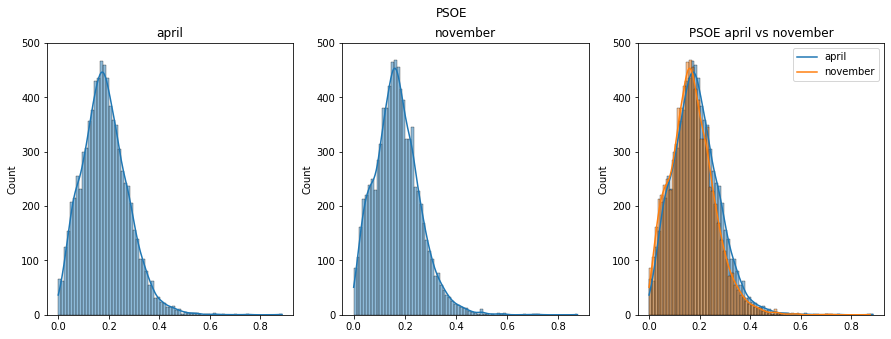

In [27]:
fig, axs = plt.subplots(1, 3, sharex=False, figsize=(15,5))
fig.suptitle('PSOE')
sns.histplot(ax=axs[0], x=elections2019['PSOE_apr'].values, kde=True).set_title('april')
sns.histplot(ax=axs[1], x=elections2019['PSOE_nov'].values, kde=True).set_title('november')
sns.histplot(ax=axs[2], x=elections2019['PSOE_apr'].values, kde=True)
sns.histplot(ax=axs[2], x=elections2019['PSOE_nov'].values, kde=True).set_title('PSOE april vs november')
plt.legend(['april','november'])
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
axs[2].set_ylim(0, 500)
plt.show()

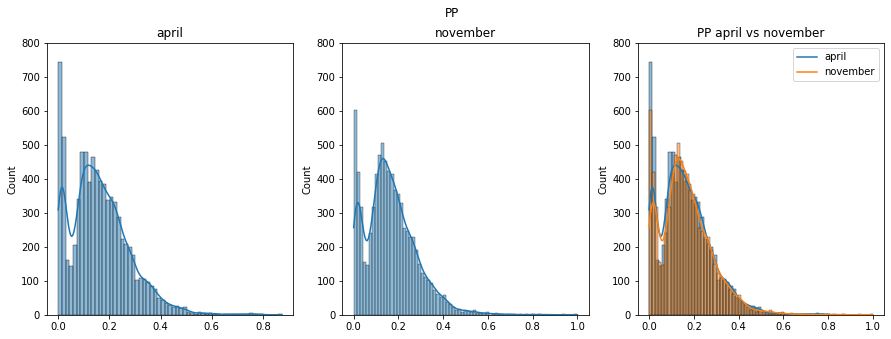

In [28]:
fig, axs = plt.subplots(1, 3, sharex=False, figsize=(15,5))
fig.suptitle('PP')
sns.histplot(ax=axs[0], x=elections2019['PP_apr'].values, kde=True).set_title('april')
sns.histplot(ax=axs[1], x=elections2019['PP_nov'].values, kde=True).set_title('november')
sns.histplot(ax=axs[2], x=elections2019['PP_apr'].values, kde=True)
sns.histplot(ax=axs[2], x=elections2019['PP_nov'].values, kde=True).set_title('PP april vs november')
plt.legend(['april','november'])
axs[0].set_ylim(0, 800)
axs[1].set_ylim(0, 800)
axs[2].set_ylim(0, 800)
plt.show()

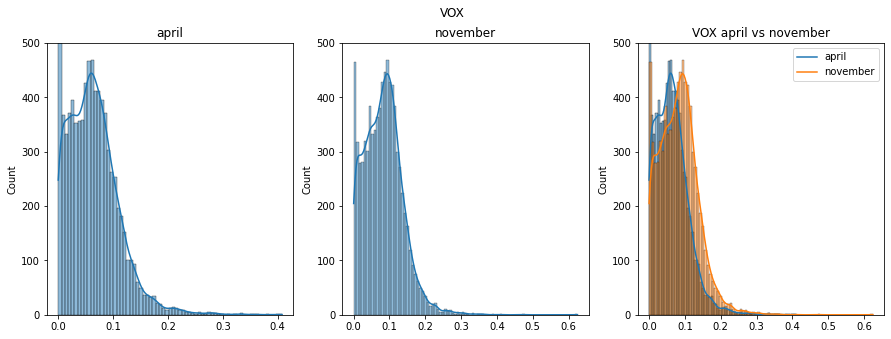

In [29]:
fig, axs = plt.subplots(1, 3, sharex=False, figsize=(15,5))
fig.suptitle('VOX')
sns.histplot(ax=axs[0], x=elections2019['VOX_apr'].values, kde=True).set_title('april')
sns.histplot(ax=axs[1], x=elections2019['VOX_nov'].values, kde=True).set_title('november')
sns.histplot(ax=axs[2], x=elections2019['VOX_apr'].values, kde=True)
sns.histplot(ax=axs[2], x=elections2019['VOX_nov'].values, kde=True).set_title('VOX april vs november')
plt.legend(['april','november'])
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
axs[2].set_ylim(0, 500)
plt.show()

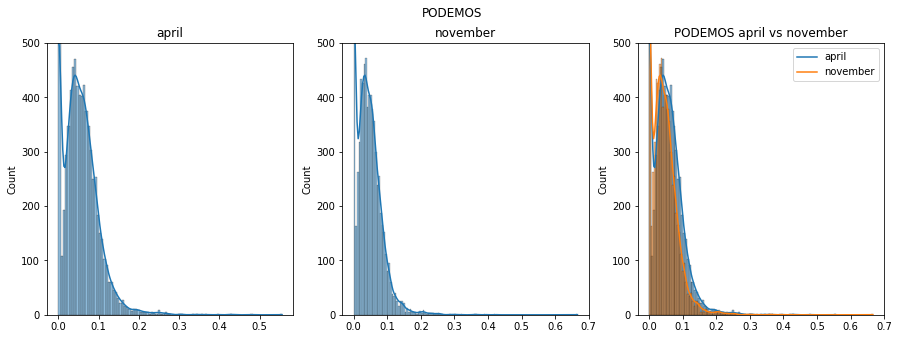

In [30]:
fig, axs = plt.subplots(1, 3, sharex=False, figsize=(15,5))
fig.suptitle('PODEMOS')
sns.histplot(ax=axs[0], x=elections2019['PODEMOS_apr'].values, kde=True).set_title('april')
sns.histplot(ax=axs[1], x=elections2019['PODEMOS_nov'].values, kde=True).set_title('november')
sns.histplot(ax=axs[2], x=elections2019['PODEMOS_apr'].values, kde=True)
sns.histplot(ax=axs[2], x=elections2019['PODEMOS_nov'].values, kde=True).set_title('PODEMOS april vs november')
plt.legend(['april','november'])
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
axs[2].set_ylim(0, 500)
plt.show()

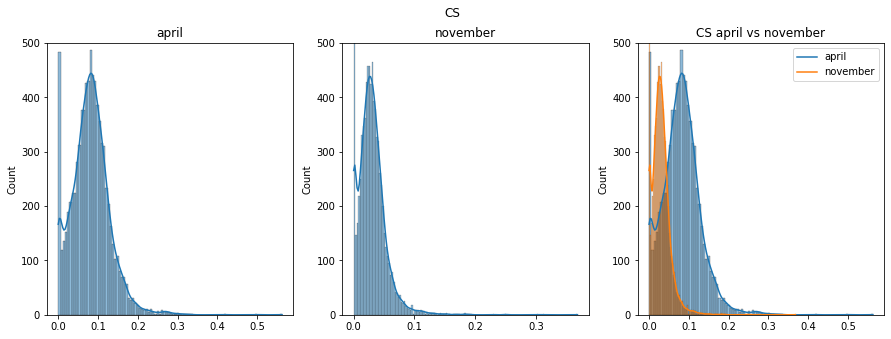

In [31]:
fig, axs = plt.subplots(1, 3, sharex=False, figsize=(15,5))
fig.suptitle('CS')
sns.histplot(ax=axs[0], x=elections2019['CS_apr'].values, kde=True).set_title('april')
sns.histplot(ax=axs[1], x=elections2019['CS_nov'].values, kde=True).set_title('november')
sns.histplot(ax=axs[2], x=elections2019['CS_apr'].values, kde=True)
sns.histplot(ax=axs[2], x=elections2019['CS_nov'].values, kde=True).set_title('CS april vs november')
plt.legend(['april','november'])
axs[0].set_ylim(0, 500)
axs[1].set_ylim(0, 500)
axs[2].set_ylim(0, 500)
plt.show()